In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [26]:
#masks = glob.glob("../input/graph_images/train/label/*.png")
masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()

orgs = glob.glob("../input/graph_images/train/image/*.png")

In [27]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):


    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    print(image)
    key = image
    print(key[-14:-9])
    graph_label = masks[key[-14:-9]]
    #im = Image.open(mask).resize((512,512))


    #width, height = im.size   # Get dimensions

    #left = (width - 388)/2
    #top = (height - 388)/2
    #right = (width + 388)/2
    #bottom = (height + 388)/2

    #im_cropped = im.crop((left, top, right, bottom))
    masks_list.append(np.array(graph_label))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

../input/graph_images/train/image\00000graph.png
00000
../input/graph_images/train/image\00001graph.png
00001
../input/graph_images/train/image\00002graph.png
00002
../input/graph_images/train/image\00003graph.png
00003
../input/graph_images/train/image\00004graph.png
00004
../input/graph_images/train/image\00005graph.png
00005
../input/graph_images/train/image\00006graph.png
00006
../input/graph_images/train/image\00007graph.png
00007
../input/graph_images/train/image\00008graph.png
00008
../input/graph_images/train/image\00009graph.png
00009
../input/graph_images/train/image\00010graph.png
00010
../input/graph_images/train/image\00011graph.png
00011
../input/graph_images/train/image\00012graph.png
00012
../input/graph_images/train/image\00013graph.png
00013
../input/graph_images/train/image\00014graph.png
00014
../input/graph_images/train/image\00015graph.png
00015
../input/graph_images/train/image\00016graph.png
00016
../input/graph_images/train/image\00017graph.png
00017
../input/g

In [28]:
print(imgs_np.shape, masks_np.shape)

(100, 512, 512) (100, 35, 37)


## Plot images + masks + overlay (mask over original)

In [29]:
from keras_unet.utils import plot_imgs

#plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [30]:
print(imgs_np.max(), masks_np.max())

255 1.0


In [31]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [32]:
print(x.max(), y.max())

1.0 0.003921569


In [33]:
print(x.shape, y.shape)

(100, 512, 512) (100, 35, 37)


In [34]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(100, 512, 512) (100, 35, 37, 1)


In [35]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(100, 512, 512, 1) (100, 35, 37, 1)


##  Train/val split

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (50, 512, 512, 1)
y_train:  (50, 35, 37, 1)
x_val:  (50, 512, 512, 1)
y_val:  (50, 35, 37, 1)


## Prepare train generator with data augmentation

In [37]:
#from keras_unet.utils import get_augmented
#
# train_gen = get_augmented(
#     x_train, y_train, batch_size=2,
#     data_gen_args = dict(
#         rotation_range=15.,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         shear_range=50,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='constant'
#     ))


(512, 512, 1) (35, 37, 1)


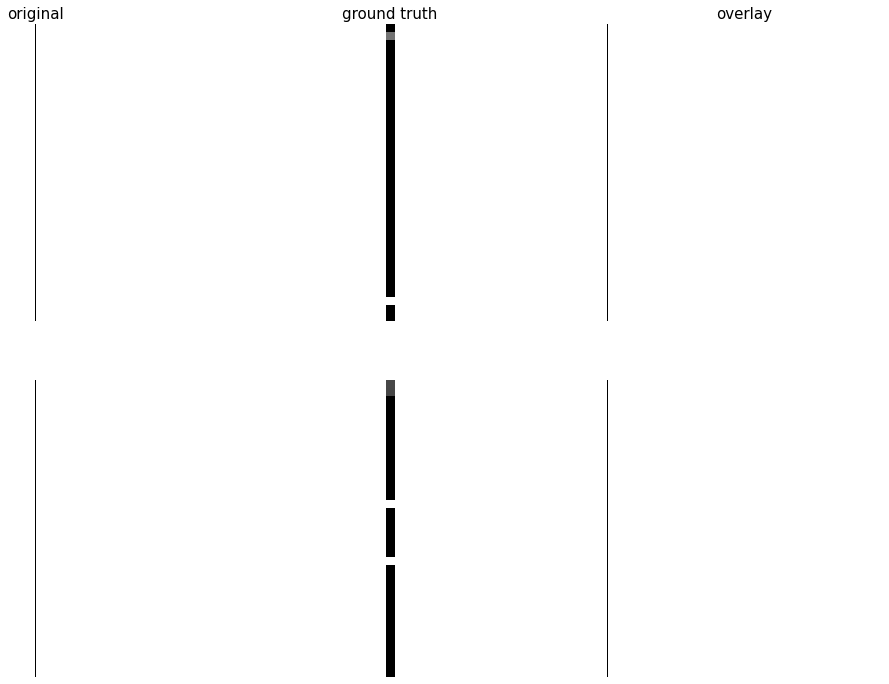

In [38]:
train_gen = zip(x_train, y_train)

sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [39]:
# from keras_unet.models import custom_unet
#
input_shape = x_train[0].shape
#
# model = custom_unet(
#     input_shape,
#     upsample_mode="deconv",  # 'deconv' or 'simple'
#     use_batch_norm=False,
#     num_classes=1,
#     filters=64,
#     dropout=0.2,
#     output_activation='relu'
# )

In [40]:
#model.summary()

In [41]:
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0, parentdir)

#from models_graph import *
from models_graph.custom_graph_head import custom_graph_head, custom_adj_unet

print(input_shape)
model = custom_adj_unet(input_size = input_shape, pretrained_weights =None)


(512, 512, 1)


In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [43]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin\\"

In [44]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files\\Graphviz\\bin\\")

print(sys.path)

['C:\\Users\\Schüle\\git\\LearnGraphExtraction\\keras-unet\\notebooks', 'C:\\Users\\Schüle\\git\\LearnGraphExtraction', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\Lib', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37\\python37.zip', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37', '', 'C:\\Users\\Schüle\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\deepwalk-1.0.3-py3.7.egg', 'c:\\users\\schüle\\git\\labelme', 'c:\\users\\schüle\\git\\learngraphextraction\\keras-unet', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Schüle\\AppData\\Local\\Pro

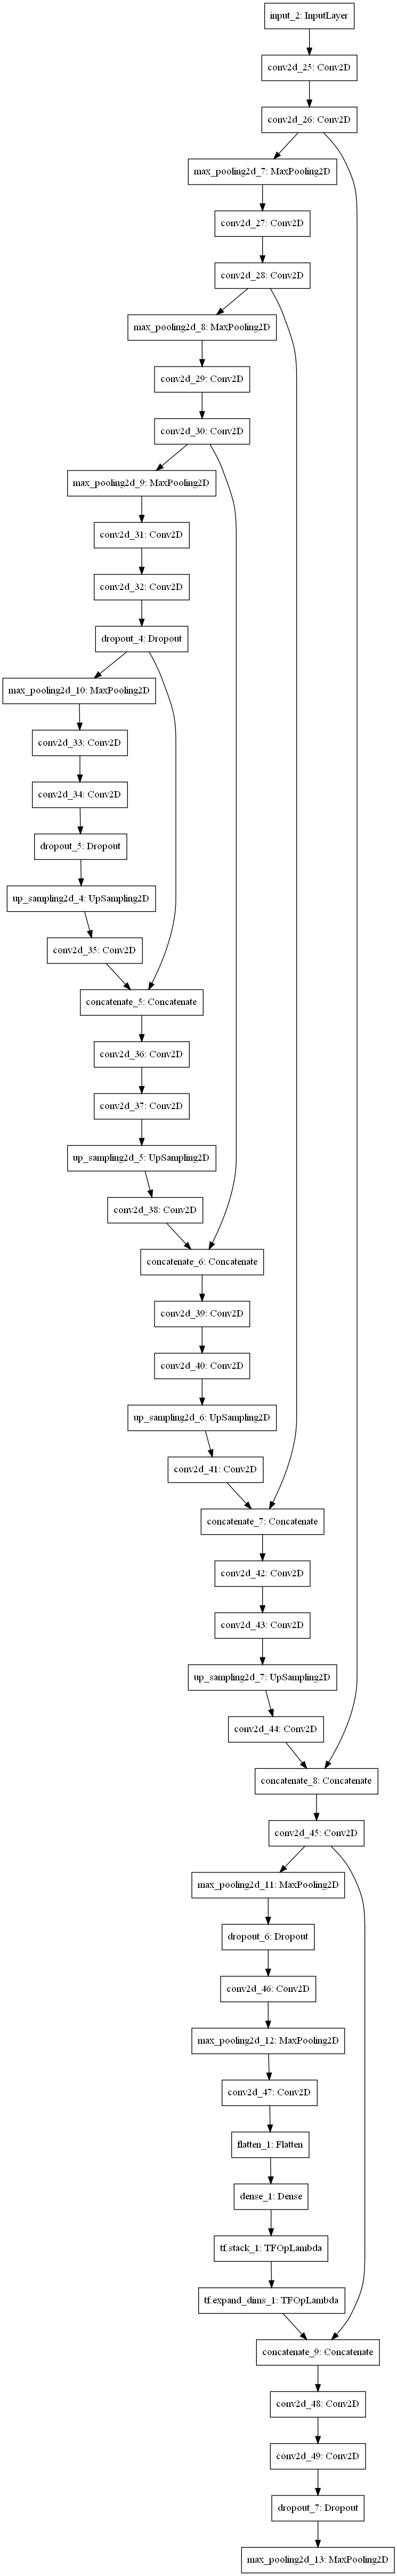

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Compile + train

In [46]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [47]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [48]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/10


InvalidArgumentError:  output dimensions must be positive
	 [[node model_1/up_sampling2d_4/resize/ResizeNearestNeighbor (defined at <ipython-input-48-c8ffb6ab900f>:7) ]] [Op:__inference_train_function_9643]

Function call stack:
train_function


## Plot training history

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)